In [54]:
from numpy import nan
import pandas as pd

def load_data():

    data = pd.read_csv('loan-train.csv')
    #data_test = pd.read_csv('loan-test.csv')

    #data = pd.concat([data_train, data_test], axis=0)

    data.drop(['Loan_ID'], axis=1, inplace=True)

    X = data.drop('Loan_Status', axis=1)
    y = data['Loan_Status']
    y = y.map({'Y': 1, 'N': 0})

    X["Gender"] = X['Gender'].map({'Male': 1, 'Female': -1})
    X["Married"] = X['Married'].map({'Yes': 1, 'No': -1})
    X["Education"] = X['Education'].map({'Graduate': 1, 'Not Graduate': -1})
    X["Self_Employed"] = X['Self_Employed'].map({'Yes': 1, 'No': -1})
    X["Dependents"] = X['Dependents'].map({'0': 0, '1': 1, '2': 2, '3+': 3})
    X["Property_Area"] = X['Property_Area'].map({'Rural': 1, 'Semiurban': 2, 'Urban': 3})
    X["Credit_History"] = X['Credit_History'].map({1.0: 1, 0.0: -1, nan: -1})

    X = pd.get_dummies(X)

    # Use Regression for numerical features and Classification for categorical features
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import RandomForestClassifier

    for feature in X.columns:
        if len(X[feature].value_counts()) <5:
            imputer = IterativeImputer(estimator=RandomForestClassifier())
            X[feature] = imputer.fit_transform(X[feature].values.reshape(-1, 1))
        else:
            imputer = IterativeImputer(estimator=RandomForestRegressor())
            X[feature] = imputer.fit_transform(X[feature].values.reshape(-1, 1))

    # standardize the data with mean 0 and std 1
    feature_standarize = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"]
    X[feature_standarize] = (X[feature_standarize] - X[feature_standarize].mean()) / X[feature_standarize].std()

    # Find the non standardized features
    X_non_standarize = X.drop(feature_standarize, axis=1)
    feature_non_standarize = X_non_standarize.columns

    # Balance the dataset
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1)
    X, y = sm.fit_resample(X, y)

    # Round the values of the features that were not standarized to integers and set them as categorical
    X[feature_non_standarize] = X[feature_non_standarize].round(0)
    X[feature_non_standarize] = X[feature_non_standarize].astype(int)

    # Remove the gender = 0 and married = 0 as they are not relevant
    y = y[X['Gender'] != 0]
    X = X[X['Gender'] != 0]
    y = y[X['Married'] != 0]
    X = X[X['Married'] != 0]
    y = y[X['Education'] != 0]
    X = X[X['Education'] != 0]

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    return X, y

X, y = load_data()

context_features = [
    "Gender",
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    'Property_Area'
]

behavioral_features = [
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term",
    "Credit_History"
]

In [55]:
# if credit history is 0 then do it -1
X["Credit_History"] = X["Credit_History"].replace(0, -1)

In [56]:
from pycaret.classification import setup, compare_models

df = pd.concat([X, y], axis=1)

# Initialize the regression setup
regression_setup = setup(data=df, target='Loan_Status', train_size=0.8,fold=5, session_id=3)

# Compare models
models = compare_models(sort='Accuracy', n_select=6)

best_model = models[0]


,Description,Value
0,Session id,3
1,Target,Loan_Status
2,Target type,Binary
3,Original data shape,"(822, 12)"
4,Transformed data shape,"(822, 12)"
5,Transformed train set shape,"(657, 12)"
6,Transformed test set shape,"(165, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7612,0.8331,0.7821,0.7569,0.7686,0.5219,0.5234,0.0460
et,Extra Trees Classifier,0.7596,0.8384,0.7522,0.7734,0.7619,0.5193,0.5205,0.0360
lightgbm,Light Gradient Boosting Machine,0.7353,0.7975,0.7284,0.7466,0.7370,0.4706,0.4711,0.2520
gbc,Gradient Boosting Classifier,0.7337,0.7676,0.8179,0.7059,0.7576,0.4655,0.4724,0.0240
xgboost,Extreme Gradient Boosting,0.7337,0.8013,0.7284,0.7458,0.7365,0.4675,0.4683,0.0220
dt,Decision Tree Classifier,0.6987,0.6989,0.6896,0.7133,0.7004,0.3975,0.3986,0.0140
ridge,Ridge Classifier,0.6957,0.0000,0.8657,0.6528,0.7438,0.3873,0.4119,0.0140
lda,Linear Discriminant Analysis,0.6942,0.7168,0.8627,0.6522,0.7423,0.3842,0.4080,0.0060
ada,Ada Boost Classifier,0.6927,0.7323,0.7881,0.6695,0.7236,0.3830,0.3896,0.0160
qda,Quadratic Discriminant Analysis,0.6896,0.6986,0.8358,0.6529,0.7327,0.3756,0.3935,0.0080


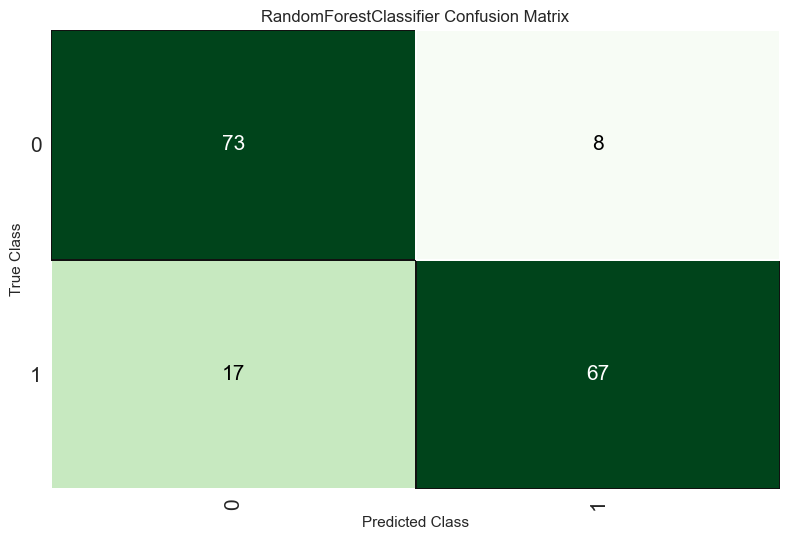

In [57]:
# Plot the confusion matrix
from pycaret.classification import plot_model
plot_model(best_model, plot='confusion_matrix')


In [58]:
# Initialize the regression setup with only contextual features
classification_setup = setup(data=df[behavioral_features + ['Loan_Status']], target='Loan_Status', train_size=0.8, fold=5)

# Compare models
models = compare_models(sort='Accuracy', n_select=3)

best_model = models[0]


,Description,Value
0,Session id,8177
1,Target,Loan_Status
2,Target type,Binary
3,Original data shape,"(822, 6)"
4,Transformed data shape,"(822, 6)"
5,Transformed train set shape,"(657, 6)"
6,Transformed test set shape,"(165, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7048,0.7751,0.7373,0.7015,0.7175,0.4086,0.4113,0.0400
lr,Logistic Regression,0.7047,0.6817,0.8925,0.6545,0.7550,0.4049,0.4373,0.0480
ridge,Ridge Classifier,0.7047,0.0000,0.8955,0.6538,0.7556,0.4048,0.4388,0.0060
lda,Linear Discriminant Analysis,0.7047,0.6827,0.8955,0.6538,0.7556,0.4048,0.4388,0.0120
rf,Random Forest Classifier,0.7002,0.7778,0.7493,0.6899,0.7175,0.3991,0.4022,0.0460
nb,Naive Bayes,0.6940,0.6869,0.8597,0.6518,0.7408,0.3839,0.4089,0.0080
qda,Quadratic Discriminant Analysis,0.6910,0.6701,0.8537,0.6501,0.7374,0.3779,0.4019,0.0100
gbc,Gradient Boosting Classifier,0.6879,0.7328,0.7791,0.6660,0.7176,0.3735,0.3803,0.0220
knn,K Neighbors Classifier,0.6834,0.7468,0.7582,0.6674,0.7095,0.3647,0.3690,0.0200
xgboost,Extreme Gradient Boosting,0.6834,0.7360,0.7134,0.6797,0.6955,0.3661,0.3677,0.0140


In [59]:
# Initialize the regression setup with only contextual features
classification_setup = setup(data=df[context_features + ['Loan_Status']], target='Loan_Status', train_size=0.8, fold=5)

# Compare models
models = compare_models(sort='Accuracy', n_select=3)

best_model = models[0]


,Description,Value
0,Session id,224
1,Target,Loan_Status
2,Target type,Binary
3,Original data shape,"(822, 7)"
4,Transformed data shape,"(822, 7)"
5,Transformed train set shape,"(657, 7)"
6,Transformed test set shape,"(165, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6073,0.6648,0.5940,0.6212,0.6063,0.2148,0.2158,0.0100
lightgbm,Light Gradient Boosting Machine,0.6027,0.6337,0.6239,0.6081,0.6150,0.2046,0.2054,0.1900
rf,Random Forest Classifier,0.5996,0.6545,0.6030,0.6113,0.6060,0.1989,0.1995,0.0380
gbc,Gradient Boosting Classifier,0.5982,0.6374,0.6537,0.5988,0.6238,0.1945,0.1961,0.0120
et,Extra Trees Classifier,0.5966,0.6501,0.5701,0.6141,0.5904,0.1939,0.1951,0.0300
dt,Decision Tree Classifier,0.5951,0.6468,0.5642,0.6128,0.5871,0.1911,0.1921,0.0060
knn,K Neighbors Classifier,0.5464,0.5656,0.5403,0.5580,0.5480,0.0927,0.0930,0.0200
ada,Ada Boost Classifier,0.5357,0.5687,0.6179,0.5397,0.5741,0.0685,0.0702,0.0160
qda,Quadratic Discriminant Analysis,0.5115,0.5058,0.5612,0.5203,0.5362,0.0209,0.0209,0.0060
dummy,Dummy Classifier,0.5099,0.5000,1.0000,0.5099,0.6754,0.0000,0.0000,0.0200


In [60]:
# train random forest classifier with grid search
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

# Create the model
model = ExtraTreesClassifier()

# Create the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20, 25]
}

# Initialize the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', refit=True)

# Fit the grid search
grid_search.fit(X, y)

# Get the best parameters
model = grid_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


## SHAP

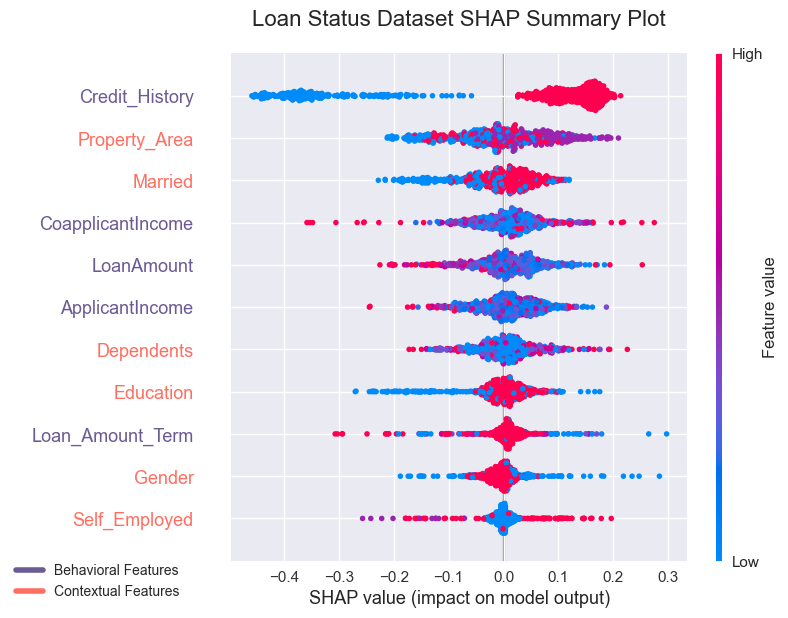

In [61]:
import shap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set the Matplotlib style
plt.style.use('seaborn')

# Create sets for faster lookup
behavioral_set = set(behavioral_features)
context_set = set(context_features)

# Create an explainer object for the gradient boosting classifier
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X)

# Create the SHAP summary plot
shap.summary_plot(shap_values[:,:,1], X, show=False)

# Get the current plot
fig = plt.gcf()
ax = plt.gca()

# Change the color of the text of feature names based on their group
for text in ax.get_yticklabels():
    feature_name = text.get_text()
    if feature_name in behavioral_set:
        text.set_color("#6B5B95")  # Change "blue" to your desired color for behavioral features
    elif feature_name in context_set:
        text.set_color("#FF6F61")  # Change "green" to your desired color for context features

# Create custom legend
legend_elements = [
    Line2D([0], [0], color='#6B5B95', lw=4, label='Behavioral Features'),
    Line2D([0], [0], color='#FF6F61', lw=4, label='Contextual Features')
]

# Add the legend outside the plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(-0.5, -0.04))

ax.set_title("Loan Status Dataset SHAP Summary Plot", fontsize=16, loc = 'center', pad=20)


# Show the plot
plt.show()

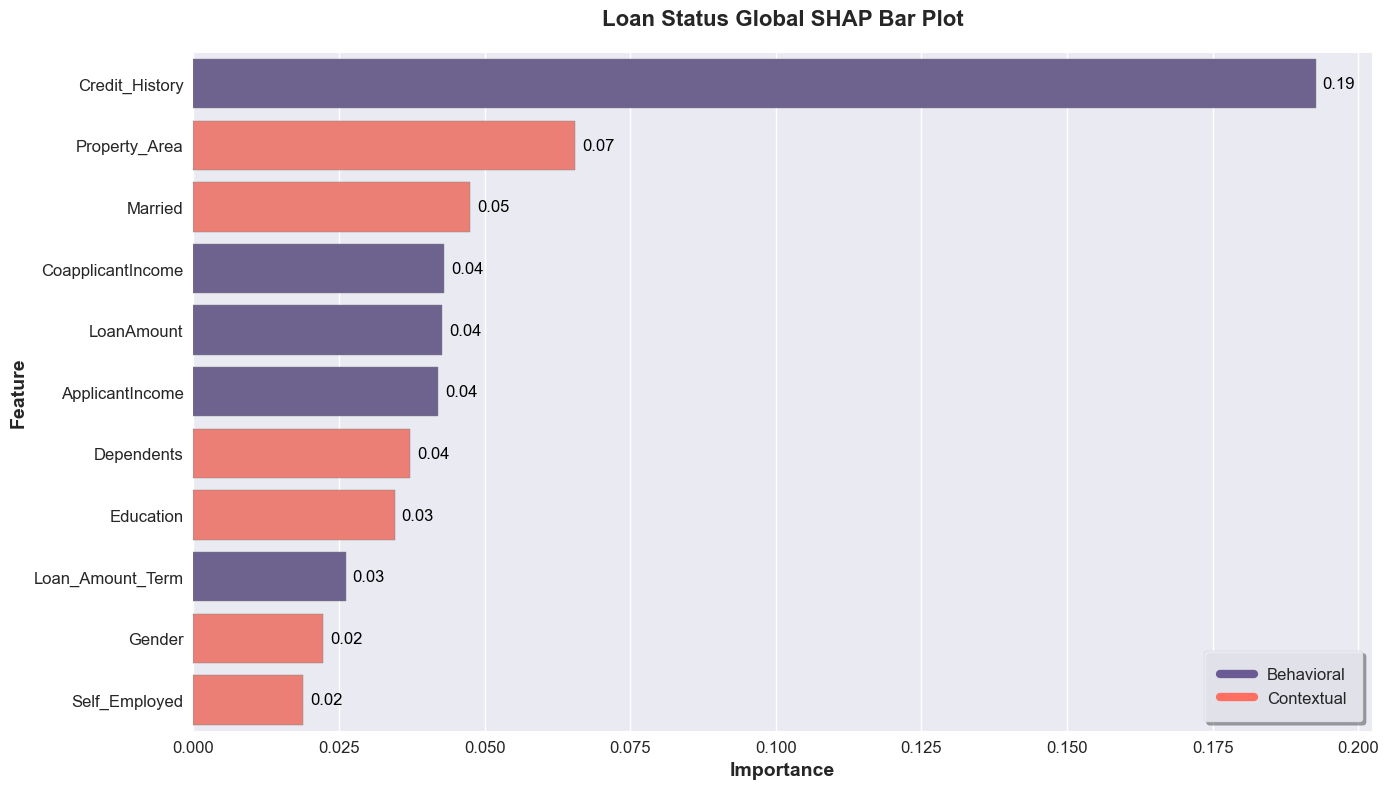

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

vals = np.abs(shap_values[:,:,0]).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True, ignore_index=True)

# Create a list of colors for the features depending on whether they are context or behavioral features
colors = []
for feature in feature_importance['col_name']:
    if feature in context_features:
        colors.append('#FF6F61')  # Modern red
    elif feature in behavioral_features:
        colors.append('#6B5B95')  # Modern blue

# Create a new column 'Color' in the 'feature_importance' dataframe
feature_importance['Color'] = colors

# Create the horizontal bar plot
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(
    x='feature_importance_vals', 
    y='col_name', 
    data=feature_importance, 
    palette=colors,
    edgecolor='grey'
)

# Customize the plot
plt.xlabel('Importance', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')
plt.title('Loan Status Global SHAP Bar Plot', fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels to the bars
for bar in bar_plot.patches:
    bar_plot.annotate(format(bar.get_width(), '.2f'), 
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                      ha='left', va='center', 
                      fontsize=12, color='black', 
                      xytext=(5, 0), 
                      textcoords='offset points')

# Customize the legend
legend_elements = [Line2D([0], [0], color='#6B5B95', lw=6, label='Behavioral'),
                   Line2D([0], [0], color='#FF6F61', lw=6, label='Contextual')]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12, frameon=True, framealpha=0.9, shadow=True, borderpad=1)

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

# Show the plot
plt.tight_layout()
plt.show()

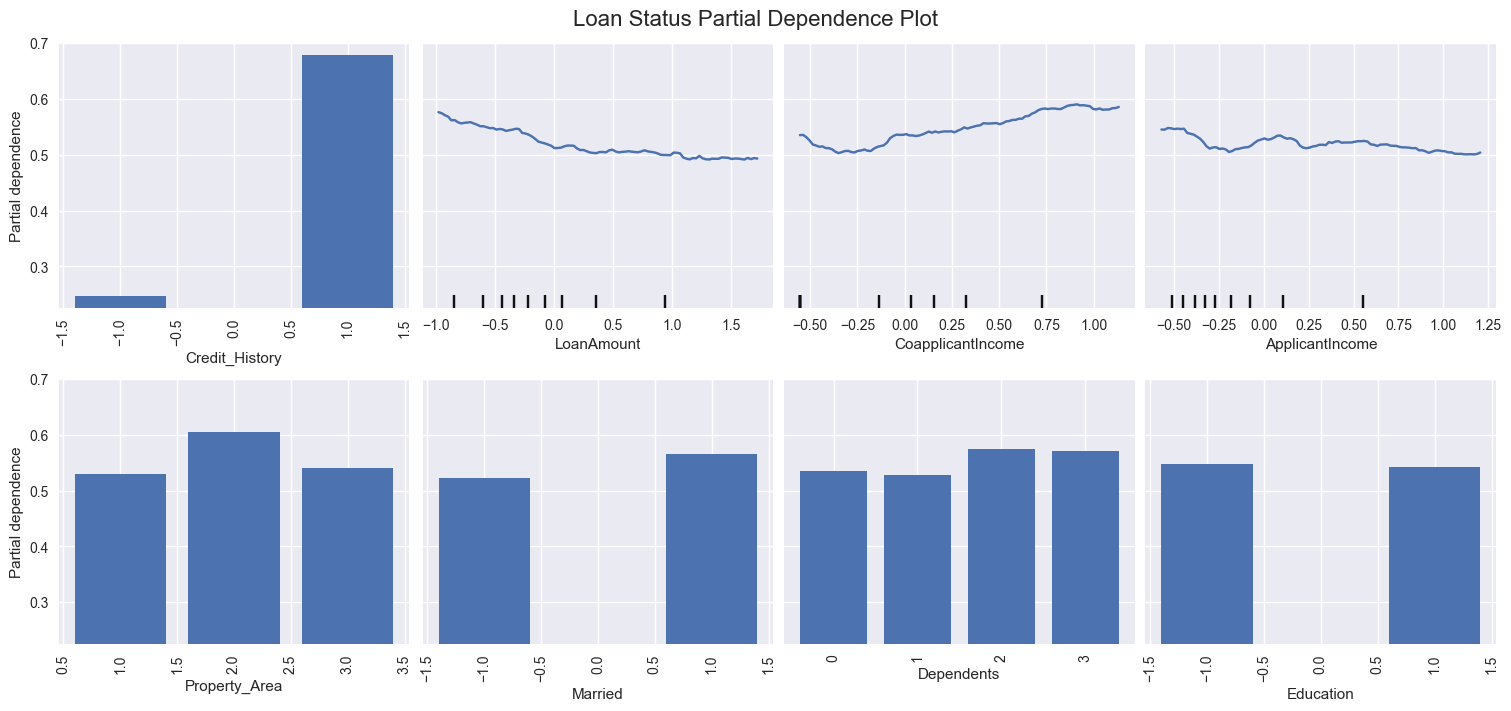

In [63]:
# Plot the Partial Dependence plot
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(15, 7), constrained_layout=True)
#fig.tight_layout(pad=3.0, w_pad=3.0, h_pad=3.0)

fig.suptitle('Loan Status Partial Dependence Plot', fontsize=16)

# Features to plot
features = ['Credit_History','LoanAmount','CoapplicantIncome','ApplicantIncome','Property_Area','Married','Dependents','Education']
cat_features = ['Property_Area','Married','Dependents','Education','Credit_History']

# Create an instance of PartialDependenceDisplay
pdp_display = PartialDependenceDisplay.from_estimator(model, X, features=features,ax=ax,categorical_features=cat_features)



## Grouped permutation feature importance

In [64]:
feature_names = X.columns.tolist()

X = X.to_numpy()
y = y.to_numpy()

In [65]:
from grouped_permutation_importance import grouped_permutation_importance
from sklearn import pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([("MinMax", MinMaxScaler()),  ("RF", RandomForestClassifier())])
cv = RepeatedStratifiedKFold()

behavioral_indexes = [feature_names.index(feature) for feature in behavioral_features]
context_indexes = [feature_names.index(feature) for feature in context_features]

idxs = [behavioral_indexes, context_indexes]

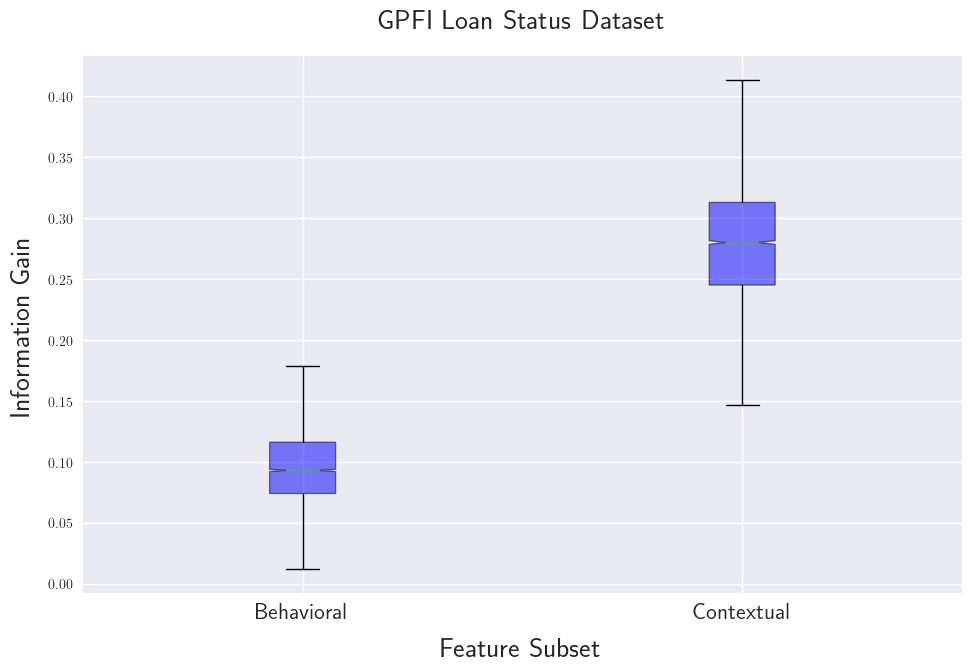

In [66]:
import matplotlib.pyplot as plt
import numpy as np

params = {'text.usetex': True,
          'font.size': 16,
          'font.family': 'sans-serif',
          'figure.figsize': (17,7)
          }
plt.rcParams.update(params)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

columns = ["Contextual", "Behavioral"]

r = grouped_permutation_importance(model, X, y, idxs=idxs,
                                   n_repeats=100, random_state=0,
                                   scoring="balanced_accuracy", n_jobs=5,
                                   cv=cv, perm_set="test")

sorted_idx = [columns.index(col) for col in columns][::-1]

# Create the boxplot
box = ax.boxplot(r.importances[sorted_idx].T,
                 patch_artist=True,
                 vert=True, showfliers=False, notch=True,
                 labels=np.array(columns)[sorted_idx])

for patch in box["boxes"]:
    patch.set_facecolor("blue")
    patch.set_alpha(.5)


ax.set_title("GPFI Loan Status Dataset", fontsize=20, pad=20)
ax.set_ylabel("Information Gain", fontsize=20, labelpad=10)
ax.set_xlabel("Feature Subset", fontsize=20, labelpad=10)
ax.set_xticklabels(np.array(columns)[sorted_idx], fontsize=16)

plt.tight_layout()
plt.show()

## Evaluating the changes of coefficients when trained on behavioral only or all features

In [67]:
#scale the features using MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = load_data()

feature_names = X.columns.tolist()

behavioral_indexes = [feature_names.index(feature) for feature in behavioral_features]
context_indexes = [feature_names.index(feature) for feature in context_features]

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [68]:
# Function to calculate standardized coefficients
from sklearn.metrics import r2_score

def calculate_standardized_coefficient(model, X, y):
    y_prob = model.predict_proba(X)[:, 1]
    logit_y_prob = np.log(y_prob / (1 - y_prob))
    R2 = r2_score(y, y_prob)
    s_logit_y_prob = np.std(logit_y_prob)
    s_logit_y = s_logit_y_prob / np.sqrt(R2)
    b = model.coef_.flatten()
    s_X = np.std(X, axis=0)
    b_star_M = b * s_X * R2 / s_logit_y_prob
    return b_star_M

In [69]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.stats import norm


# Create an instance of LogisticRegression
model = LogisticRegression()

# Number of bootstrap samples
n_iterations = 100

# Store the coefficients for all iterations
coefficients_boot = []
coefficients_behavioral_boot = []
coefficients_context_boot = []

# Assuming X_scaled, y, behavioral_features, and context_features are defined
for i in range(n_iterations):
    # Resample the data with replacement
    X_scaled_resampled, y_resampled = resample(X_scaled, y, replace=True)
    X_scaled_behavioral_resampled = X_scaled_resampled[behavioral_features]
    X_scaled_context_resampled = X_scaled_resampled[context_features]

    # Fit the model to the resampled data and calculate standardized coefficients
    model.fit(X_scaled_resampled, y_resampled)
    standardized_coefficients = calculate_standardized_coefficient(model, X_scaled_resampled, y_resampled)
    coefficients_boot.append(standardized_coefficients)

    model.fit(X_scaled_behavioral_resampled, y_resampled)
    standardized_coefficients_behavioral = calculate_standardized_coefficient(model, X_scaled_behavioral_resampled, y_resampled)
    coefficients_behavioral_boot.append(standardized_coefficients_behavioral)

    model.fit(X_scaled_context_resampled, y_resampled)
    standardized_coefficients_context = calculate_standardized_coefficient(model, X_scaled_context_resampled, y_resampled)
    coefficients_context_boot.append(standardized_coefficients_context)

# Convert to numpy arrays for easier calculations
coefficients_boot = np.array(coefficients_boot)
coefficients_behavioral_boot = np.array(coefficients_behavioral_boot)
coefficients_context_boot = np.array(coefficients_context_boot)

# Calculate mean and standard errors of the coefficients
mean_coefficients = np.mean(coefficients_boot, axis=0)
mean_coefficients_behavioral = np.mean(coefficients_behavioral_boot, axis=0)
mean_coefficients_context = np.mean(coefficients_context_boot, axis=0)

std_error_coefficients = np.std(coefficients_boot, axis=0)
std_error_coefficients_behavioral = np.std(coefficients_behavioral_boot, axis=0)
std_error_coefficients_context = np.std(coefficients_context_boot, axis=0)

# Compute Z-test statistics
z_statistics_behavioral = (mean_coefficients[behavioral_indexes] - mean_coefficients_behavioral) / np.sqrt(std_error_coefficients[behavioral_indexes]**2 + std_error_coefficients_behavioral**2)
z_statistics_context = (mean_coefficients[context_indexes] - mean_coefficients_context) / np.sqrt(std_error_coefficients[context_indexes]**2 + std_error_coefficients_context**2)

# Calculate p-values
p_values_behavioral = norm.sf(np.abs(z_statistics_behavioral)) * 2  # two-tailed p-value
p_values_context = norm.sf(np.abs(z_statistics_context)) * 2  # two-tailed p-value

# Determine significance
alpha = 0.05
significant_changes_behavioral = p_values_behavioral < alpha
significant_changes_context = p_values_context < alpha

# get the feature names of the significant changes
significant_behavioral_features = np.array(behavioral_features)[significant_changes_behavioral]
significant_context_features = np.array(context_features)[significant_changes_context]

# Output results
print("Significant behavioral features:", significant_behavioral_features)
print("Significant context features:", significant_context_features)

# Calculate confidence intervals (e.g., 95% CI) for each coefficient
lower_percentile = 2.5
median = 50
upper_percentile = 97.5

confidence_intervals = np.percentile(coefficients_boot, [lower_percentile, median, upper_percentile], axis=0)
confidence_intervals_behavioral = np.percentile(coefficients_behavioral_boot, [lower_percentile, median, upper_percentile], axis=0)
confidence_intervals_context = np.percentile(coefficients_context_boot, [lower_percentile, median, upper_percentile], axis=0)

Significant behavioral features: []
Significant context features: ['Married']


In [70]:
coefficients_df = pd.DataFrame(confidence_intervals.T, columns= ["Lower", "Median", "Upper"], index=X_scaled.columns)
coefficients_behavioral_df = pd.DataFrame(confidence_intervals_behavioral.T, columns= ["Lower_bh", "Median_bh", "Upper_bh"], index=X_scaled[behavioral_features].columns)
coefficients_context_df = pd.DataFrame(confidence_intervals_context.T, columns= ["Lower_con", "Median_con", "Upper_con"], index=X_scaled[context_features].columns)

In [71]:
coefficients_behavioral_df = pd.DataFrame.merge(coefficients_df.loc[behavioral_features],coefficients_behavioral_df, left_index=True, right_index=True)
coefficients_context_df = pd.DataFrame.merge(coefficients_df.loc[context_features],coefficients_context_df, left_index=True, right_index=True)

# Sort the coefficients by the median value
coefficients_behavioral_df = coefficients_behavioral_df.sort_values(by='Median', ascending=False)
coefficients_context_df = coefficients_context_df.sort_values(by='Median', ascending=False)

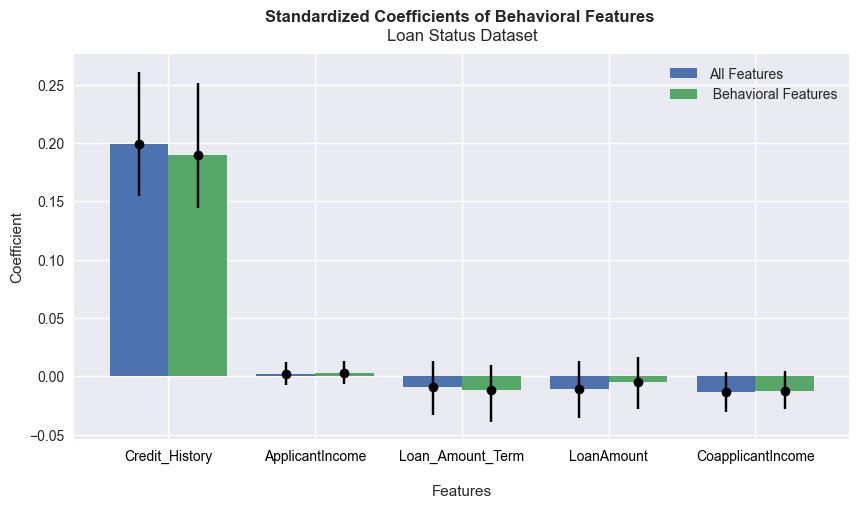

In [72]:
# Highlight the features that have significant changes
from numpy import pad

highlight_features = significant_behavioral_features

# Reset the Matplotlib modifications
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn')

# Create barplot for all features and behavioral features
X_axis = np.arange(len(coefficients_behavioral_df.index))
plt.figure(figsize=(10,5))

plt.bar(X_axis - 0.2,coefficients_behavioral_df["Median"],0.4,label="All Features")
plt.bar(X_axis + 0.2,coefficients_behavioral_df["Median_bh"],0.4,label=" Behavioral Features")


# Change the color of the ticks for highlighted features
xticks_colors = ['red' if feature in highlight_features else 'black' for feature in coefficients_behavioral_df.index]

# Add the confidence intervals for the coefficients
plt.errorbar(X_axis - 0.2, coefficients_behavioral_df["Median"], yerr=[coefficients_behavioral_df["Median"] - coefficients_behavioral_df["Lower"], coefficients_behavioral_df["Upper"] - coefficients_behavioral_df["Median"]], fmt='o', color='black', capsize=5)
plt.errorbar(X_axis + 0.2, coefficients_behavioral_df["Median_bh"], yerr=[coefficients_behavioral_df["Median_bh"] - coefficients_behavioral_df["Lower_bh"], coefficients_behavioral_df["Upper_bh"] - coefficients_behavioral_df["Median_bh"]], fmt='o', color='black', capsize=5)

plt.xticks(X_axis, coefficients_behavioral_df.index)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), xticks_colors):
    ticklabel.set_color(tickcolor)

plt.suptitle("Standardized Coefficients of Behavioral Features", fontsize=12, fontweight='bold', y=0.97, x=0.51)
plt.title("Loan Status Dataset", fontsize=12, pad=10)

plt.xlabel('Features',labelpad=15)
plt.ylabel('Coefficient')
plt.legend()
plt.show()


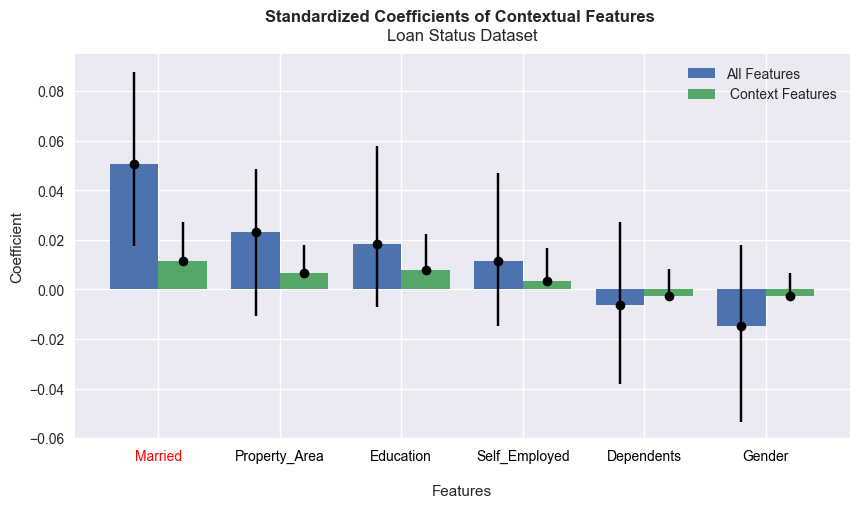

In [73]:
# Highlight the features that have significant changes
highlight_features = significant_context_features

# Create barplot for all features and behavioral features
plt.figure(figsize=(10,5))
X_axis = np.arange(len(coefficients_context_df.index))

plt.bar(X_axis - 0.2,coefficients_context_df["Median"],0.4,label="All Features")
plt.bar(X_axis + 0.2,coefficients_context_df["Median_con"],0.4,label=" Context Features")


# Change the color of the ticks for highlighted features
xticks_colors = ['red' if feature in highlight_features else 'black' for feature in coefficients_context_df.index]

# Add the confidence intervals for the coefficients
plt.errorbar(X_axis - 0.2, coefficients_context_df["Median"], yerr=[coefficients_context_df["Median"] - coefficients_context_df["Lower"], coefficients_context_df["Upper"] - coefficients_context_df["Median"]], fmt='o', color='black', capsize=5)
plt.errorbar(X_axis + 0.2, coefficients_context_df["Median_con"], yerr=[coefficients_context_df["Lower_con"] - coefficients_context_df["Lower_con"], coefficients_context_df["Upper_con"] - coefficients_context_df["Median_con"]], fmt='o', color='black', capsize=5)
             
plt.xticks(X_axis, coefficients_context_df.index)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), xticks_colors):
    ticklabel.set_color(tickcolor)

plt.suptitle("Standardized Coefficients of Contextual Features", fontsize=12, fontweight='bold', y=0.97, x=0.51)
plt.title("Loan Status Dataset", fontsize=12, pad=10)

plt.xlabel('Features',labelpad=15)
plt.ylabel('Coefficient')
plt.legend()
plt.show()


## Sensitivity Analysis

In [74]:
# Create the initial dataframe with 'feature' column
results = pd.DataFrame(columns=['y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Add columns 'y_1' to 'y_n' to the dataframe
for i in range(1, len(X_test)+1):
    results[f'{i}'] = None

model = LogisticRegression()

model.fit(X_train[behavioral_features], y_train)
y_pred = model.predict_proba(X_test[behavioral_features])[:, 0]

new_row = pd.DataFrame([["y_test"] + list(y_test)], columns=results.columns)
results = results.append(new_row, ignore_index=True)

# Create a new row with the label "Only Behavioral" and the values of y_pred
new_row = pd.DataFrame([["Only_Behavioral"] + list(y_pred)], columns=results.columns)

# Append the new row to the results dataframe
results = results.append(new_row, ignore_index=True)

f = "Gender"

sens_analysis_features = behavioral_features + [f]

model = LogisticRegression()

# Fit the model to the behavioral features plus one contextual feature
model.fit(X_train[sens_analysis_features], y_train)

# Create DataFrame for first iteration
temp = X_test[sens_analysis_features]

for i in [-1, 1]:
    # Replace the values of sex column with the value of i
    temp[f] = i

    # Predict the target variable using the trained model
    y_pred = model.predict_proba(temp)[: , 0]

    new_row = pd.DataFrame([[f"sex_{i}"] + list(y_pred)], columns=results.columns)

    # Append the new row to the results dataframe
    results = results.append(new_row, ignore_index=True)  

results = results.T
new_header = results.iloc[0] 
results = results[1:] 
results.columns = new_header
results



y,y_test,Only_Behavioral,sex_-1,sex_1
1,1,0.334368,0.364873,0.325407
2,1,0.337282,0.382239,0.341905
3,0,0.820802,0.840873,0.816074
4,0,0.808891,0.828654,0.802399
5,1,0.3402,0.372337,0.332486
...,...,...,...,...
161,1,0.34352,0.375125,0.335135
162,1,0.33322,0.362866,0.323506
163,1,0.333333,0.362923,0.32356
164,0,0.348166,0.380799,0.340533


In [75]:
results_def = results.copy()
results_def["sex_-1"] = results["sex_-1"] - results["Only_Behavioral"]
results_def['sex_1'] = results["sex_1"] - results["Only_Behavioral"]

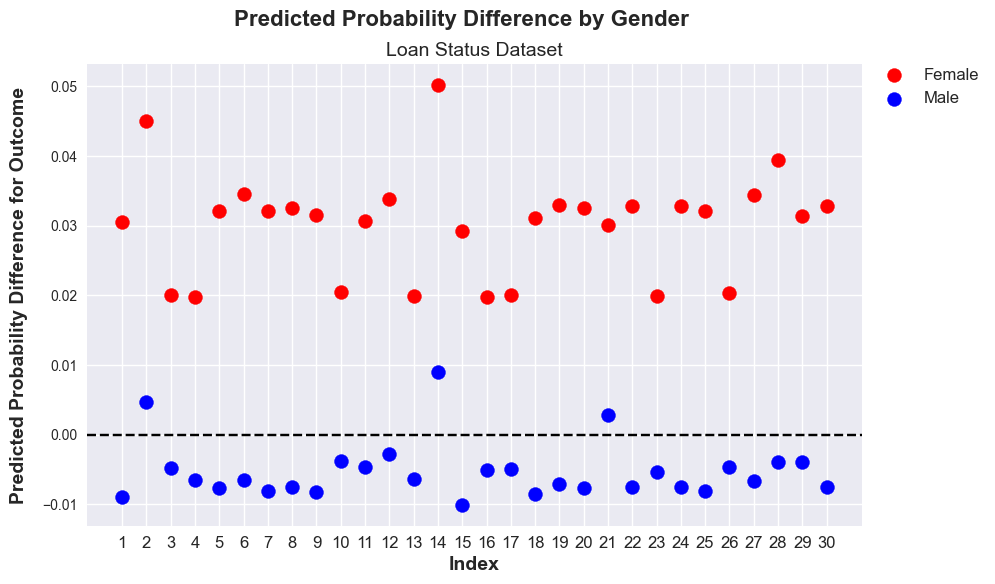

-0.005264234105234966

In [76]:
import matplotlib.pyplot as plt

plt.rcParams.update()
plt.style.use('seaborn')

# Select the first 10 rows of the dataframe
df_subset = results_def.head(30)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_subset.index, df_subset['sex_-1'], color='red', label='Female', s=100)
plt.scatter(df_subset.index, df_subset['sex_1'], color='blue', label='Male', s=100)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--')

# Set the labels and title
plt.xlabel('Index', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Probability Difference for Outcome', fontsize=14, fontweight='bold', labelpad=10)
plt.suptitle('Predicted Probability Difference by Gender', fontsize=16, fontweight='bold', y=0.97)
plt.title('Loan Status Dataset', fontsize=14,)
plt.xticks(fontsize=12)

# move the legend location outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.95), fontsize=12)

# Show the plot
plt.show()

#avg_Female = results['sex_-1'].mean()
#avg_Male = results['sex_1'].mean()

#print(f"Average of Female: {avg_Female}")
#print(f"Average of Behavioral Only: {avg_Behavioral}")
#print(f"Average of Male: {avg_Male}")

df_subset['sex_1'].mean()


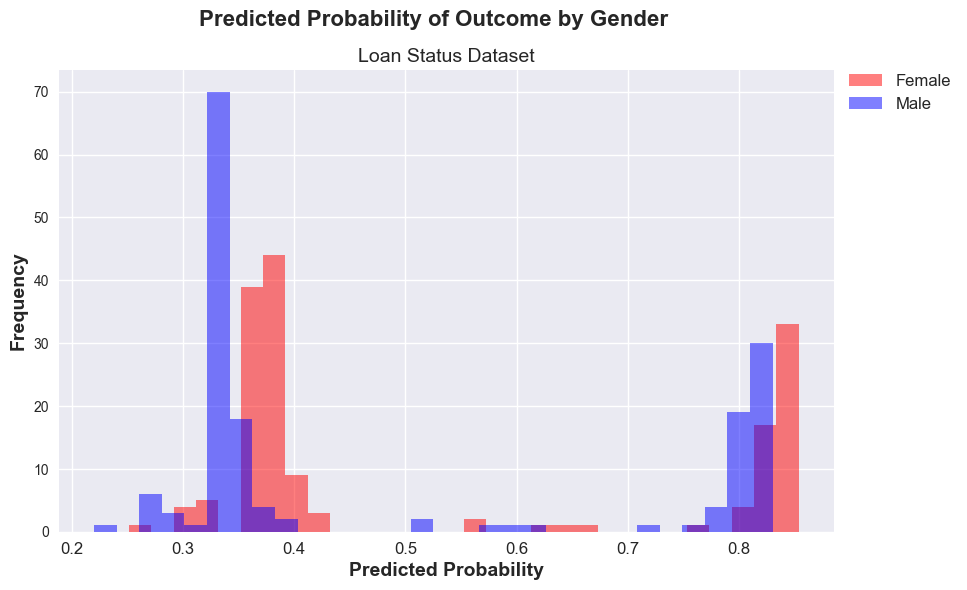

In [77]:
prob_male = results['sex_1']
prob_female = results['sex_-1']

# Plotting
plt.figure(figsize=(10, 6))

plt.hist(prob_female, bins=30, alpha=0.5, label='Female', color='red')
plt.hist(prob_male, bins=30, alpha=0.5, label='Male', color='blue')

plt.xlabel('Predicted Probability', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.suptitle('Predicted Probability of Outcome by Gender',fontsize=16, fontweight='bold')
plt.title('Loan Status Dataset', fontsize=14,)
plt.xticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.95), fontsize=12)
plt.show()

## LUPI

In [100]:
X, y = load_data()

behavioral_indexes = [X.columns.get_loc(feature) for feature in behavioral_features]
print(behavioral_indexes)

[5, 6, 7, 8, 9]


In [101]:
import argparse
import lupi_svm as lupi
import warnings
warnings.filterwarnings("ignore")

parser = argparse.ArgumentParser()

parser.add_argument("--nJobs", help="number of processors available", default=6, type=int)
parser.add_argument("--dataset", help="the dataset file", default='student-por.csv', type=str)
parser.add_argument("--cv_score", help="cv_score: f1, accuracy", default='accuracy', type=str)
parser.add_argument("--cv_kfold", help="number of folds for cross validation", default=6, type=int)
parser.add_argument("--test_size", help="test_size: 0.25, 0.3, 0.33", default=0.2, type=float)
parser.add_argument("--pri_features", nargs='+', help="privileged features", default=[5, 6, 7, 8])

args, unknown = parser.parse_known_args()
nJobs = args.nJobs

test_size = args.test_size

# The dataset file name is input by --dataset argument
# We use the UCI parkinsons dataset as an example
# The dataset can be download with the following command. run the command from current directory

dataset_file = args.dataset

# load the dataset from the dataset file to pandas data frmae
print("... Loading the dataset: {}.".format(dataset_file))
#data_set = pd.read_csv(dataset_file, header=0, delim_whitespace=False, sep=';')

... Loading the dataset: student-por.csv.


In [102]:
# Privileged feature indices
pri_features = behavioral_indexes

col_length = len(X.columns)
range_col = range(col_length)

# Get the indices of the standard features
standard_features = [i for i in range_col if i not in pri_features]

In [103]:
# standardize the data with mean 0 and std 1
feature_standarize = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"]
X[feature_standarize] = (X[feature_standarize] - X[feature_standarize].mean()) / X[feature_standarize].std()


In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# Define the hyperparameters and their possible values
param_grid = [
    {'kernel': ['linear'], 'C': np.logspace(-2, 2, 6)},  # linear kernel with a wider range for C
    {'kernel': ['rbf'], 'C': np.logspace(-2, 3, 6), 'gamma': np.logspace(-4, 1, 6)},  # RBF kernel with a range for gamma
]

# Create an instance of the SVC model
svm = SVC()

# Create a GridSearchCV object with the SVM classifier and the hyperparameter grid
grid_search = GridSearchCV(svm, param_grid, cv=5,n_jobs=7)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict the target variable for the test data
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

NameError: name 'train_test_split' is not defined

In [83]:
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train.iloc[:,standard_features], y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the test data
y_pred = best_model.predict(X_test.iloc[:,standard_features])

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5991902834008097


In [84]:
# We use pri_features for the privileged feature list
pri_features = list(map(int, args.pri_features))

# set the privileged features in the test set to 0 so that the privileged information is removed
X_test.iloc[:, pri_features] = 0

# set up the lupi regressor grid search parameters
regr_param_grid_dict = dict(gamma_list=[-2.0, 6.5, 0.4], C_list=[-2.5, 6.0, 0.4])

# set up the svm grid search parameters
svc_param_grid_dict = dict(gamma_list=[-2.0, 6.5, 0.4], C_list=[-2.5, 6.0, 0.4])

# set up cross validation KFlod and score function
cv_kfold = args.cv_kfold
cv_score = args.cv_score

app = lupi.App(svc_param_grid_dict=svc_param_grid_dict,
               regr_param_grid_dict=regr_param_grid_dict)

krr_param_grid = app.get_krr_param_grid()
svc_param_grid = app.get_svc_param_grid()

# Create the lupi classifer, train with training set and predict on the test set.
lupi_clf = lupi.Composer(pri_features=pri_features,
                         krr_param_grid=krr_param_grid,
                         svc_param_grid=svc_param_grid,
                         nJobs=nJobs,
                         cv=cv_kfold,
                         cv_score=cv_score,
                         random_state=1)

print("... model training ...")
lupi_clf.fit(X_train, y_train)

print("... predicting on test data...")
y_pred = lupi_clf.predict(X_test, type='ln')

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

... model training ...
... predicting on test data...
0.7165991902834008


## LUPI KNN WEIGHTED 

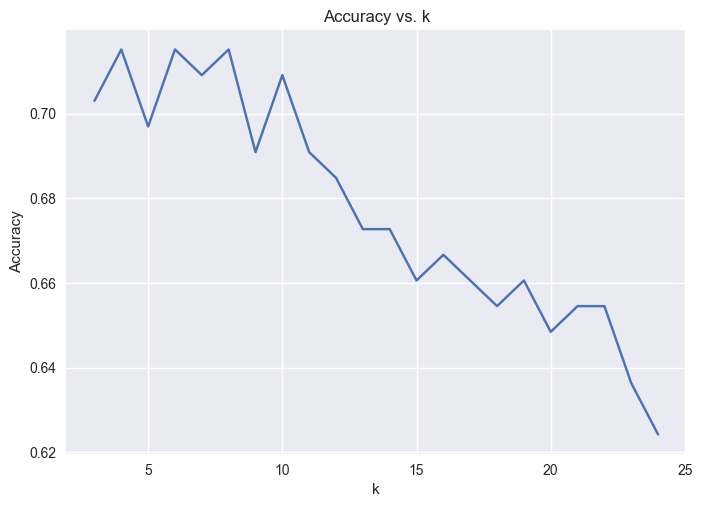

The best k value is: 4
The accuracy of the model with the best k value is: 0.7151515151515152


In [110]:
# Run knn with different k values and plot the accuracy
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a list of k values
k_values = list(range(3, 25))

# Create an empty list to store the accuracy values
accuracy_values = []

# Loop through the k values
for k in k_values:
    # Create an instance of the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model to the training data
    knn.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = knn.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy value to the list
    accuracy_values.append(accuracy)

# Plot the accuracy values
plt.plot(k_values, accuracy_values)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.show()

best_k = np.argmax(accuracy_values)
print("The best k value is:", k_values[best_k])
print("The accuracy of the model with the best k value is:", accuracy_values[best_k])

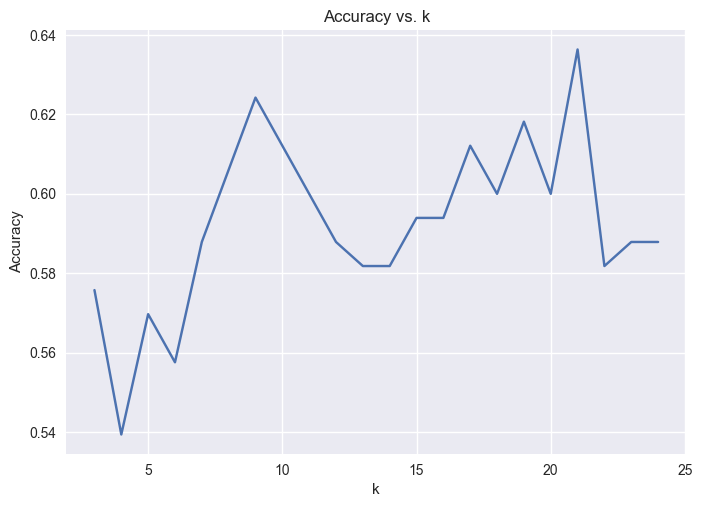

The best k value is: 21


In [115]:
# Run knn with different k values and plot the accuracy
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X[context_features], y, test_size=0.2, random_state=0)

# Create a list of k values
k_values = list(range(3, 25))

# Create an empty list to store the accuracy values
accuracy_values = []

# Loop through the k values
for k in k_values:
    # Create an instance of the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model to the training data
    knn.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = knn.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy value to the list
    accuracy_values.append(accuracy)

# Plot the accuracy values
plt.plot(k_values, accuracy_values)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.show()

best_k = np.argmax(accuracy_values)
print("The best k value is:", k_values[best_k])

In [116]:
# Train the KNN model with the best k value
knn = KNeighborsClassifier(n_neighbors=k_values[best_k])

# Fit the model to the training data
knn.fit(X[context_features], y)

# Get the neighbors for each instance in the test set
distances, indices = knn.kneighbors(X[context_features])

# Calculate the voting ratio for each test instance
ratios = []
for i, instance_indices in enumerate(indices):
    # Get the classes of the neighbors
    neighbor_classes = y[instance_indices]
    # Count how many neighbors have the same class as the instance
    instance_class = y[i]
    same_class_count = np.sum(neighbor_classes == instance_class)
    # Calculate the ratio
    ratio = same_class_count / k
    ratios.append(ratio)

weights = pd.DataFrame({
    'Instance': np.arange(1, len(ratios) + 1),
    'Same_Class_Ratio': ratios
})


In [117]:
# Calculate the same class ratio for each instance with a random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the RandomForestClassifier
rf = RandomForestClassifier()

# Fit the model to the training data
rf.fit(X[context_features], y)

# Get the predicted probabilities for the test data
y_pred_prob = rf.predict_proba(X[context_features])

# Calculate the same class ratio for each instance
ratios = []

for i, prob in enumerate(y_pred_prob):
    # Get the predicted probability for the instance
    instance_prob = prob[1]
    # Calculate the ratio
    ratio = instance_prob
    ratios.append(ratio)

weights['Random_Forest_Ratio'] = ratios

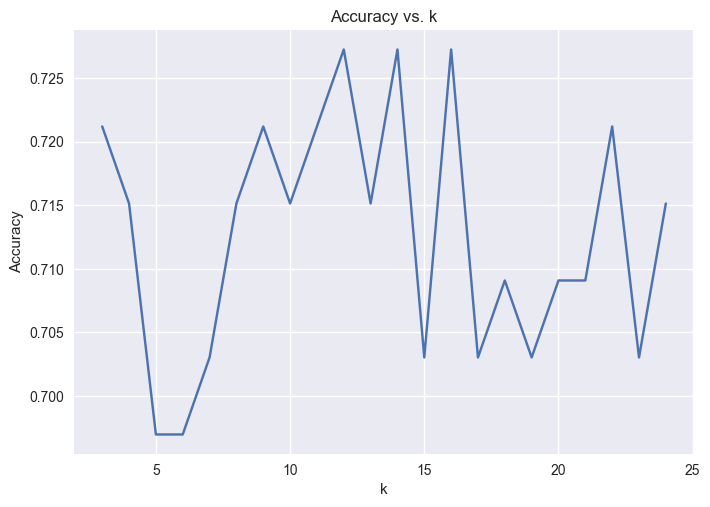

The best k value is: 12
The best accuracy is: 0.7272727272727273


In [118]:
# Run knn with different k values and plot the accuracy

X_train, X_test, y_train, y_test = train_test_split(X[behavioral_features], y, test_size=0.2, random_state=0)

# Create a list of k values
k_values = list(range(3, 25))

# Create an empty list to store the accuracy values
accuracy_values = []

# Loop through the k values
for k in k_values:
    # Create an instance of the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model to the training data
    knn.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = knn.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy value to the list
    accuracy_values.append(accuracy)

# Plot the accuracy values
plt.plot(k_values, accuracy_values)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.show()

best_k = np.argmax(accuracy_values)
print("The best k value is:", k_values[best_k])
print("The best accuracy is:", accuracy_values[best_k])

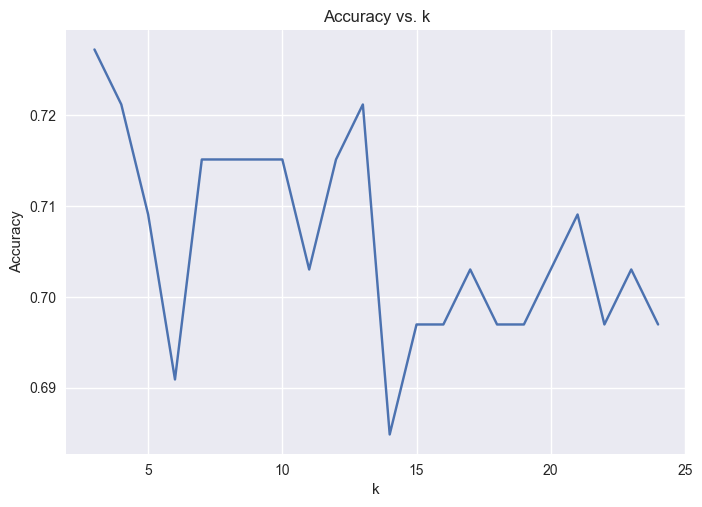

The best k value is: 3
The accuracy is: 0.7272727272727273


In [119]:
def weighted_knn_predict(X_train, y_train, X_test, weights_df, k=5):
    from sklearn.metrics import euclidean_distances
    predictions = []

    # Compute distances between each test instance and all training instances
    distances = euclidean_distances(X_test, X_train)

    for test_instance in enumerate(X_test.index):
        # Get distances for the current test instance
        dists = distances[test_instance[0]]
        # Find the indices of the k nearest neighbors
        nn_indices = np.argsort(dists)[:k]
        # Get the classes of the nearest neighbors
        nn_classes = y_train.iloc[nn_indices]
        # Get the weights of the nearest neighbors from weights_df
        nn_weights = weights_df.loc[nn_indices, 'Same_Class_Ratio'].values

        # Calculate weighted probabilities for each class
        unique_classes = np.unique(y_train)
        class_probabilities = {}
        for cls in unique_classes:
            class_weights = nn_weights[nn_classes == cls]
            class_probabilities[cls] = np.sum(class_weights)

        # Normalize the probabilities
        total_weight = np.sum(nn_weights)
        for cls in class_probabilities:
            class_probabilities[cls] /= total_weight

        # Predict the class with the highest probability
        predicted_class = max(class_probabilities, key=class_probabilities.get)
        predictions.append(predicted_class)

    return predictions

X_train, X_test, y_train, y_test = train_test_split(X[behavioral_features], y, test_size=0.2, random_state=0)

# Train the weighted KNN model with many k values and plot the accuracy
k_values = list(range(3, 25))
accuracy_values = []

for k in k_values:
    predictions = weighted_knn_predict(X_train, y_train, X_test, weights, k=k)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_values.append(accuracy)

plt.plot(k_values, accuracy_values)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.show()

best_k = np.argmax(accuracy_values)
print("The best k value is:", k_values[best_k])
print("The accuracy is:", accuracy_values[best_k])